# Part 1: Station Metadata

In [5]:
import subprocess
import re
import station_pb2_grpc, station_pb2, grpc
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, corr
from cassandra.cluster import Cluster
try:
    cluster = Cluster(['project-5-k-5-db-1', 'project-5-k-5-db-2', 'project-5-k-5-db-3'])
    session = cluster.connect()
except Exception as e:
    print(e)

In [6]:
session.execute("drop keyspace if exists weather")

In [7]:
session.execute("""
create keyspace weather
with replication={'class': 'SimpleStrategy','replication_factor': 3};
""")
session.execute("use weather")
session.execute("create type weather.station_record (tmin int, tmax int)")
session.execute("""
CREATE TABLE stations (
    id text,
    name text STATIC,
    date date,
    record weather.station_record,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
""")

In [8]:
# Q1: what is the schema?
print(session.execute("describe keyspace weather").one().create_statement)
print(session.execute("describe table weather.stations").one().create_statement)

CREATE KEYSPACE weather WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '3'}  AND durable_writes = true;
CREATE TABLE weather.stations (
    id text,
    date date,
    name text static,
    record station_record,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
    AND additional_write_policy = '99p'
    AND bloom_filter_fp_chance = 0.01
    AND caching = {'keys': 'ALL', 'rows_per_partition': 'NONE'}
    AND cdc = false
    AND comment = ''
    AND compaction = {'class': 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy', 'max_threshold': '32', 'min_threshold': '4'}
    AND compression = {'chunk_length_in_kb': '16', 'class': 'org.apache.cassandra.io.compress.LZ4Compressor'}
    AND crc_check_chance = 1.0
    AND default_time_to_live = 0
    AND extensions = {}
    AND gc_grace_seconds = 864000
    AND max_index_interval = 2048
    AND memtable_flush_period_in_ms = 0
    AND min_index_interval = 128
    AND read_repair = 'BLOCKING'
  

In [9]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("p5")
         .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.2.0')
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .getOrCreate())

:: loading settings :: url = jar:file:/usr/local/lib/python3.10/dist-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-de3fe7a9-e0e9-498d-a386-27a8445afb9f;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.2.0 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.2.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.gith

In [10]:
df = spark.read.text("ghcnd-stations.txt")

In [11]:
query = session.prepare("INSERT INTO weather.stations (id, name) VALUES (?, ?)")

for row in df.collect():
    if row.value[38:40] == "WI":
        sid = row.value[:11]
        station = row.value[41:71]
        session.execute(query, (sid, station))

In [12]:
# Q2: what is the token of the vnode that comes first after the partition for the USC00470273 sensor?
output = subprocess.check_output(['nodetool', 'ring'])
tokens = re.findall(r'(-?\d{5,})',output.decode())[1:]
result_set = session.execute("SELECT token('USC00470273') FROM weather.stations")
for row in result_set:
    row_token = row[0]
    break
print(f"row token:   {row_token}")
for i in range(len(tokens)):
    if row_token < int(tokens[i]):
        if (i + 1) == len(tokens):
            print(f"vnode token: {tokens[0]}") 
        else:
            print(f"vnode token: {tokens[i+1]}")
        break
    else:
        print(f"vnode token: {tokens[0]}") 

row token:   -9014250178872933741
vnode token: -8707563176684402373


# Part 2: Temperature Data

In [15]:
%%capture
!wget https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations.zip
!apt-get install zip -y
!unzip wi-stations.zip -d wi-stations

In [16]:
channel = grpc.insecure_channel("localhost:5440")
stub = station_pb2_grpc.StationStub(channel)

def simulate_sensor(station):
    df = pd.read_csv(f'wi-stations/{station}.csv.gz', compression='gzip', header = None)[[1,2,3]]
    df = df.loc[(df[2] == 'TMAX') | (df[2] == 'TMIN')]
    df = df.pivot(index=1, columns=2, values=3)
    df = df.reset_index(level=0)
    df[1] = pd.to_datetime(df[1], format='%Y%m%d')
    df = df[df[1].dt.year == 2022]
    df[1] = df[1].dt.date
    for row in df.iterrows():
        date = str(row[1][1])
        tmax = int(row[1]['TMAX'])
        tmin = int(row[1]['TMIN'])
        resp = stub.RecordTemps(station_pb2.RecordTempsRequest(station = station, date = date, tmin = tmin, tmax = tmax))

for station in ["USW00014837", "USR0000WDDG", "USW00014898", "USW00014839"]:
    simulate_sensor(station)
    r = stub.StationMax(station_pb2.StationMaxRequest(station=station))
    if r.error:
        print(r.error)
    else:
        print(f"max temp for {station} is {r.tmax}")

/tmp/ipykernel_215/2835517823.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'wi-stations/{station}.csv.gz', compression='gzip', header = None)[[1,2,3]]


max temp for USW00014837 is 356
max temp for USR0000WDDG is 344


/tmp/ipykernel_215/2835517823.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'wi-stations/{station}.csv.gz', compression='gzip', header = None)[[1,2,3]]


max temp for USW00014898 is 356


/tmp/ipykernel_215/2835517823.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'wi-stations/{station}.csv.gz', compression='gzip', header = None)[[1,2,3]]


max temp for USW00014839 is 378


# Part 3: Spark Analysis

In [17]:
spark.conf.set("spark.sql.catalog.cassandra", "com.datastax.spark.connector.datasource.CassandraCatalog")
spark.conf.set("spark.sql.catalog.cassandra.spark.cassandra.connection.host", "project-5-k-5-db-1:9042")
spark.table("cassandra.weather.stations").createOrReplaceTempView("weather2022")
spark.table("weather2022").cache()

DataFrame[id: string, date: date, record: struct<tmin:int,tmax:int>, name: string]

In [18]:
def convert(degree):
    return degree * 0.18 + 32
convertUDF = udf(lambda d: convert(d))
spark.udf.register("convertUDF", convertUDF)

<function __main__.<lambda>(d)>

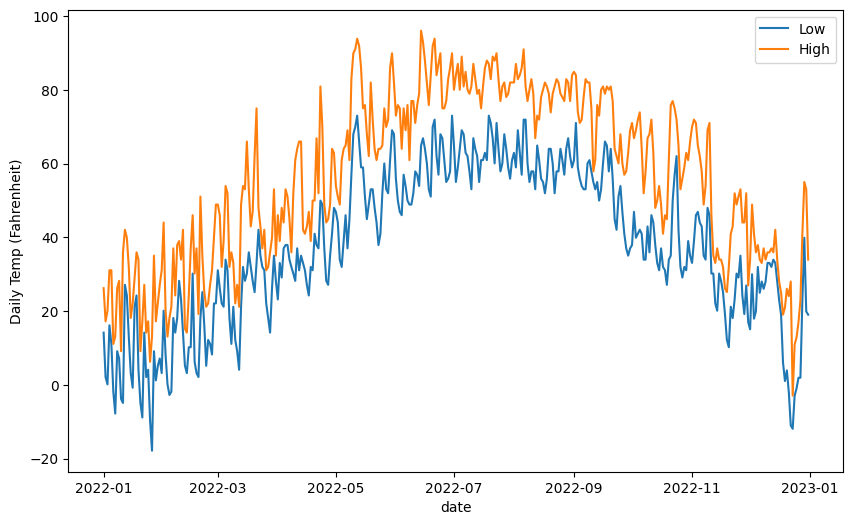

In [19]:
# Q3: what were the daily highs and lows at Madison's airport in 2022?
result = spark.sql("""
SELECT date, convertUDF(record.tmin) as low, convertUDF(record.tmax) as high
FROM weather2022
WHERE id = 'USW00014837'
""").toPandas()
result['low'] = result['low'].astype(float)
result['high'] = result['high'].astype(float)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(result['date'], result['low'], label='Low')
ax.plot(result['date'], result['high'], label='High')

ax.set_xlabel('date')
ax.set_ylabel('Daily Temp (Fahrenheit)')
ax.legend()
plt.show()

In [20]:
# Q4: what is the correlation between maximum temperatures in Madison and Milwaukee?
df = spark.sql("""
SELECT date, CAST(record.tmax AS BIGINT) as mad_high, CAST(high AS BIGINT)
FROM weather2022
LEFT JOIN (
    SELECT date as mil_date, record.tmax as high
    FROM weather2022
    WHERE id = 'USW00014839'
) ON weather2022.date = mil_date
WHERE id = 'USW00014837'
""")
df.agg(corr("mad_high", "high").alias('Corr')).collect()

[Row(Corr=0.9786907979650685)]

# Part 4: Disaster Strikes

In [21]:
# Q5: does StationMax still work?
stub.StationMax(station_pb2.StationMaxRequest(station="USW00014837"))

23/04/15 04:23:19 WARN ChannelPool: [s0|/172.21.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=9d40c354-7c4f-41fc-b7f6-7bf98b6ee148, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681532336587}): failed to send request (java.nio.channels.NotYetConnectedException))


_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Exception calling application: bad argument type for built-in operation"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:5440 {created_time:"2023-04-15T04:23:22.628162623+00:00", grpc_status:2, grpc_message:"Exception calling application: bad argument type for built-in operation"}"
>

In [22]:
# Q6: does simulate_sensor still work?
simulate_sensor("USC00477115")

23/04/15 04:23:26 WARN ChannelPool: [s0|/172.21.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=9d40c354-7c4f-41fc-b7f6-7bf98b6ee148, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681532336587}): failed to send request (java.nio.channels.NotYetConnectedException))


In [23]:
# Q7: how does refreshing the stale cache change the number of rows in weather2022?
before = spark.sql("""
SELECT COUNT(record)
FROM weather2022
""").toPandas().iloc[0][0]
spark.table("weather2022").unpersist()
spark.table("weather2022").cache()
after = spark.sql("""
SELECT COUNT(record)
FROM weather2022
""").toPandas().iloc[0][0]
print(f"BEFORE REFRESH: {before}")
print(f"AFTER REFRESH: {after}")

BEFORE REFRESH: 1460
AFTER REFRESH: 1825


23/04/15 04:23:35 WARN ChannelPool: [s0|/172.21.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=9d40c354-7c4f-41fc-b7f6-7bf98b6ee148, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681532336587}): failed to send request (java.nio.channels.NotYetConnectedException))
23/04/15 04:23:47 WARN ChannelPool: [s0|/172.21.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=9d40c354-7c4f-41fc-b7f6-7bf98b6ee148, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681532336587}): failed to send request (java.nio.channels.NotYetConnectedException))
23/04/15 04:24:02 WARN ChannelPool: [s0|/172.21.0.3:9042]  Err